In [1]:
!pip install yfinance

In [2]:
!pip install -U matplotlib --user

Requirement already up-to-date: matplotlib in c:\users\belya\appdata\roaming\python\python37\site-packages (3.4.2)


In [3]:
!pip install seaborn

### Import required packages

In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib as mpl
import scipy.stats as si

### Get data from yahoo finance

In [5]:
tick='FB' 
start="2020-10-01"
end="2021-06-30"
df = yf.download(tick,start,end)

[*********************100%***********************]  1 of 1 completed


In [6]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-06-23,339.350006,343.420013,338.200012,340.589996,340.589996,14817800
2021-06-24,341.850006,344.899994,341.790009,343.179993,343.179993,12329100
2021-06-25,342.589996,344.119995,339.679993,341.369995,341.369995,14594400
2021-06-28,342.459991,358.140015,341.769989,355.640015,355.640015,29156100
2021-06-29,356.269989,356.739990,349.049988,351.890015,351.890015,21417300


### Describe Data and Draw Price Graph

In [7]:
df=df['Adj Close']
df.describe().round(2)

count    188.00
mean     287.74
std       25.66
min      245.64
25%      267.65
50%      277.46
75%      306.67
max      355.64
Name: Adj Close, dtype: float64

In [8]:
Price = df[-1]
print('The spot price is', round(Price,2))

The spot price is 351.89


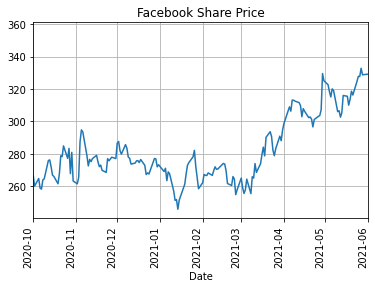

In [9]:
df.plot(label=tick)
plt.xlabel('Date')
plt.title('Facebook Share Price')
plt.xticks(rotation=90)
plt.xlim('2020-10','2021-6')
plt.grid()

### Calculate return and moving averages and add to new data frame

In [10]:
ret=np.log(df/df.shift(1)) 
data=pd.concat([df,ret], axis=1) 
data.columns=['Price', 'Return'] 
data.dropna(inplace=True) 
data.tail()

,Price,Return
Date,,
2021-06-23,340.589996,0.004591
2021-06-24,343.179993,0.007576
2021-06-25,341.369995,-0.005288
2021-06-28,355.640015,0.040952
2021-06-29,351.890015,-0.010600


In [12]:
w=5                                  
data['min'] = data['Price'].rolling(w).min()
data['max'] = data['Price'].rolling(w).max()
data['std'] = data['Price'].rolling(w).std()
data['mean'] = data['Price'].rolling(w).mean()
data['median'] = data['Price'].rolling(w).median()
data['ewma'] = data['Price'].ewm(halflife=0.5, min_periods=14).mean()
data.dropna().head()

,Price,Return,min,max,std,mean,median,ewma
Date,,,,,,,,
2020-10-20,267.559998,0.023292,261.399994,271.820007,3.729493,266.685999,266.720001,266.338791
2020-10-21,278.730011,0.040900,261.399994,278.730011,6.418470,268.067999,266.720001,275.632206
2020-10-22,278.119995,-0.002191,261.399994,278.730011,7.713958,270.347998,267.559998,277.498048
2020-10-23,284.790009,0.023699,261.399994,284.790009,9.433099,274.120001,278.119995,282.967018
2020-10-26,277.109985,-0.027338,267.559998,284.790009,6.199074,277.262000,278.119995,278.574244


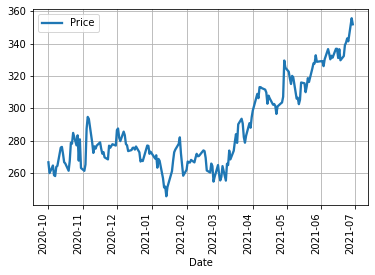

In [40]:
data[['Price']].plot(subplots=True, lw=2.3, grid=True)
plt.xticks(rotation=90)
plt.show()

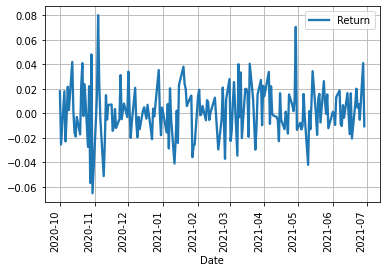

In [41]:
data[['Return']].plot(subplots=True, lw=2.3, grid=True)
plt.xticks(rotation=90)
plt.show()

### Cumulative Returns

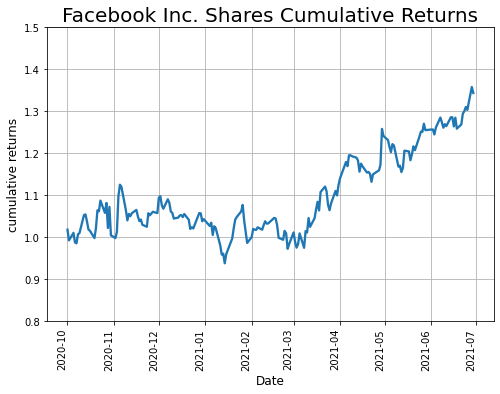

In [46]:
data['Return'].cumsum().apply(np.exp).plot(figsize=(8, 6), lw=2.3)
plt.grid(True)
plt.xticks(rotation=90)
plt.xlabel('Date',fontsize=12)
plt.title('Facebook Inc. Shares Cumulative Returns', fontsize=20)
plt.ylabel('cumulative returns',fontsize=12)
plt.ylim(0.8,1.5)
plt.show()

### Distribution of Stock Return

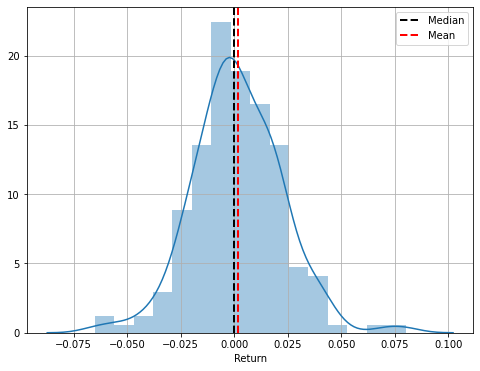

In [47]:
plt.figure(figsize=(8,6))
ax=sns.distplot(data['Return'])
ax.axvline(data['Return'].median(), color='black', ls='--', label='Median',lw=2)
ax.axvline(data['Return'].mean(), color='red', ls='--', label='Mean',lw=2)
plt.legend(loc=0)
plt.grid(True)

In [48]:
data['Return'].describe()

count    187.000000
mean       0.001579
std        0.020931
min       -0.065177
25%       -0.011511
50%       -0.000059
75%        0.015327
max        0.079944
Name: Return, dtype: float64

We use 5 and 20 Moving Days Averages and compare them with the Price.

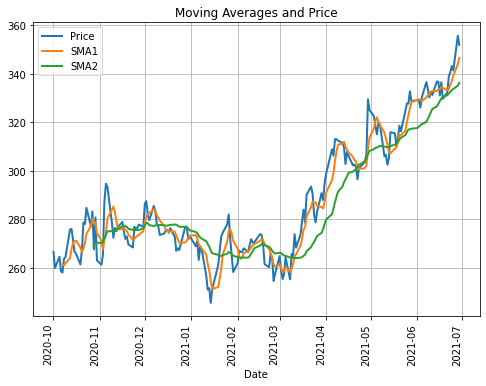

In [49]:
SMA1=5
SMA2=20
data['SMA1'] = data['Price'].rolling(window=SMA1).mean()
data['SMA2'] = data['Price'].rolling(window=SMA2).mean()
data[['Price', 'SMA1', 'SMA2']].plot(figsize=(8,6), grid=True, lw=2)
plt.title('Moving Averages and Price')
plt.xticks(rotation=90)
plt.show()

### Option Pricing


#### MonteCarlo Simulation


Monte Carlo simulation is a model used to predict the probability of different outcomes when the intervention of random variables is present. In our case, we use it to simulate the price of an underlying assets. Here we use 3000 simulation to simulate prices. Then we use payoff function max(K-S,0) to value the Put Option.

In [50]:
def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return S

In [51]:
T = 1/12                                              # One month maturity or time to expiration
r = 1.48/100                                          # US risk free rate as of July 1,2021
sigma = data['Return'].std()*np.sqrt(len(data))       #annual volatility 
S0 = data['Price'][-1]                                #last price of the stock
K = 350                                               #strike price
q=0                                                   #FB do not pay divident

In [52]:
S = mcs_simulation_np(3000) # 3000 simulations for the stock price
S = np.transpose(S)
S

array([[351.89001465, 351.59487834, 351.20140167, ..., 367.65060727,
        368.62029913, 368.73698892],
       [351.89001465, 351.51256447, 351.97952281, ..., 382.74836823,
        382.24974058, 382.70728199],
       [351.89001465, 352.00559273, 352.49236029, ..., 324.04778025,
        324.60361573, 324.35854176],
       ...,
       [351.89001465, 351.92658416, 351.90516381, ..., 372.38372391,
        372.25503697, 372.85829   ],
       [351.89001465, 351.89088783, 352.631065  , ..., 388.55241792,
        388.50685052, 388.37554734],
       [351.89001465, 352.12704527, 351.65278337, ..., 360.08644723,
        359.82755737, 360.13510253]])

Text(0.5, 1.0, 'Frequency Distribution of the Simulated End-of-Preiod Values')

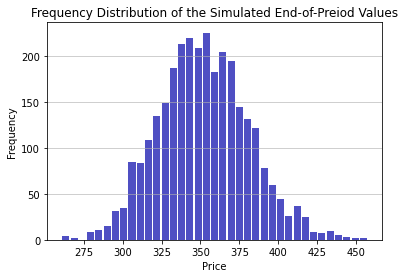

In [53]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of the Simulated End-of-Preiod Values')

In [54]:
print('Mean of Simulated Prices is {} and standard deviation is "{}!"'.format(S.mean().round(2), S.std().round(2)))

Mean of Simulated Prices is 352.03 and standard deviation is "20.47!"


In [55]:
p = np.mean(np.maximum(K - S[:,-1],0))
print('European put', str(p))

European put 10.485489595869343


### Black Scholes Merton Model

Black Scholes Merton model uses last price,strike, time to expiry, risk free rate, divident yield and annual volatility to price an option. 

In [56]:
def euro_put_bsm(S, K, T, r, q, vol):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #q: continuous dividend yield
    #vol: volatility of underlying asset
 
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    #if payoff == "call":
        
    #option_value = S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    #elif payoff == "put":
    option_value =  - S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0,1.0)
    
    return option_value

In [57]:
euro_put_bsm(S0,K,T,r,q,sigma)

10.43443450505896

In [58]:
TX = np.linspace(0.25,3,12)
cpd = np.zeros((len(TX),1))
for i in range(len(TX)):
    cpd [i] = euro_put_bsm(S0, K, TX[i], r, q, sigma) 

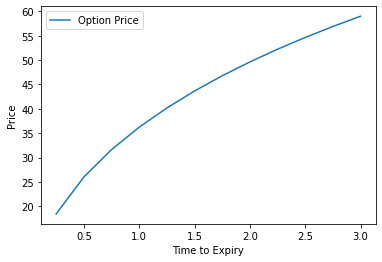

In [59]:
fig = plt.figure()
plt.plot(TX, cpd, '-')
plt.xlabel('Time to Expiry')
plt.ylabel('Price')
#plt.title('European Put')
plt.legend(['Option Price'])

In [60]:
SI = np.linspace(300,900,11)               
cp = np.zeros((len(SI),1))
for i in range(len(SI)):
    cp[i] = euro_put_bsm(SI[i], K, T, r, q, sigma)

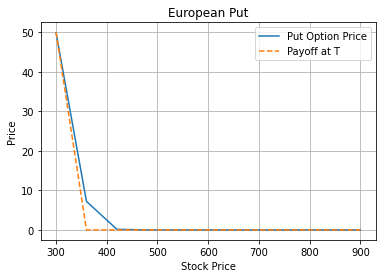

In [61]:
fig = plt.figure()
plt.plot(SI, cp, '-')                    
plt.plot(SI, np.maximum(K-SI,0), '--')   
plt.xlabel('Stock Price')
plt.ylabel('Price')
plt.title('European Put')
plt.legend(['Put Option Price','Payoff at T'])
plt.grid()

### Greeks

#### Delta

Delta is a measure of the change in an option's price (that is, the premium of an option) resulting from a change in the underlying security. The value of delta ranges from -100 to 0 for puts and 0 to 100 for calls (-1.00 and 1.00 without the decimal shift, respectively)

In [62]:
def delta(S, K, T, r, q, vol):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    delta =  - np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0)
    
    return delta

In [63]:
delta(S0, K, T, r, q, sigma)

-0.45167993656953426

In [70]:
SD = np.linspace(S0-200,S0+300,51) 
Delta_Put = np.zeros((len(SD),1))  
for i in range(len(SD)):
    Delta_Put [i] = delta(SD[i], K, T, r, q, sigma)

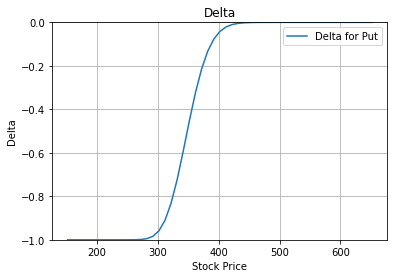

In [71]:
fig = plt.figure()
plt.plot(SD, Delta_Put, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.title('Delta')
plt.ylim(-1,0)
plt.legend(['Delta for Put'])
plt.show()

In [72]:
SD1=np.linspace(S0-200,S0+200,51) 
TD=np.linspace(0.5,2,31)        
Delta = np.zeros((len(TD),len(SD1)))
for j in range(len(SD1)):
    for i in range(len(TD)):
        Delta[i,j] = delta(SD1[j], K, TD[i], r, q, r)

C:\Users\belya\New folder\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


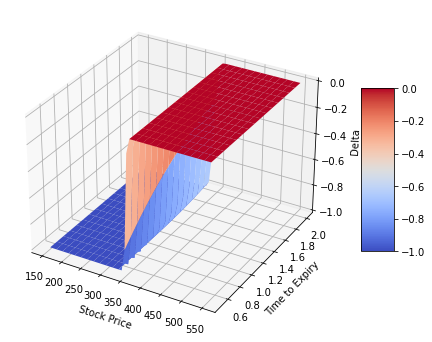

In [73]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d') #Get the current Axes instance on the current figure matching the given keyword args.
SD1, TD = np.meshgrid(SD1, TD) # extend dimention of the matrix (2D to 3D)
surf = ax.plot_surface(SD1, TD, Delta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Delta')
fig.colorbar(surf, shrink=0.5, aspect=5);

#### Gamma

Gamma measures the rate of changes in delta over time. Since delta values are constantly changing with the underlying asset's price, gamma is used to measure the rate of change and provide traders with an idea of what to expect in the future.

In [74]:
def gamma(S, K, T, r, q, vol):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(-r * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * T)
    
    return gamma

In [75]:
gamma(S0, K, T, r, q, sigma)

0.04712256904425527

In [76]:
SG = np.linspace(S0-200,S0+300,21)
Gamma = np.zeros((len(SG),1))
for i in range(len(SG)):
    Gamma [i] = gamma(SG[i], K, T, r, q, sigma)

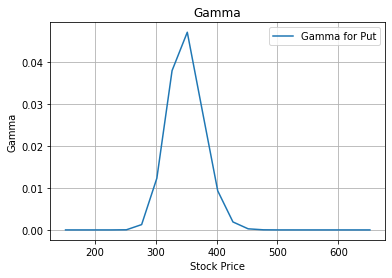

In [77]:
fig = plt.figure()
plt.plot(SG, Gamma, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Put'])

#### Speed

Measures gamma sensitivity to price change.

In [78]:
def speed(S, K, T, r, q, vol):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * T) * (d1 + vol * np.sqrt(T))
    
    return speed

In [79]:
speed(S0,K,T,r,q,sigma)

9.558015127555175e-05

In [80]:

SP = np.linspace(S0-200,S0+300,21)
Speed = np.zeros((len(SP),1))
for i in range(len(SP)):
    Speed [i] = speed(SP[i], K, T, r, q, sigma)

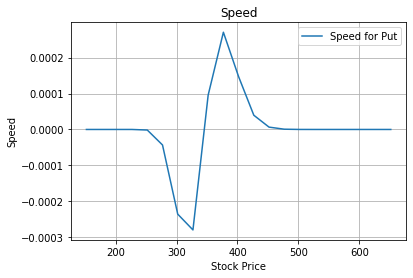

In [81]:
fig = plt.figure()
plt.plot(SP, Speed, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Speed')
plt.title('Speed')
plt.legend(['Speed for Put'])

#### Vega

Vega measures the risk of changes in implied volatility or the forward-looking expected volatility of the underlying asset price. While delta measures actual price changes, vega is focused on changes in expectations for future volatility.

In [82]:
def vega(S, K, T, r, q, vol):
    # theata of put option
    #S: stock price
    #K: strike price 
    # r: annual risk free rate
    #q: divident yield
    #vol: annual volatility 
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    vega = S * np.sqrt(T) * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0)
    
    return vega

In [83]:
vega(S0, K, T, r, q, sigma)

40.22769269806688

In [84]:
vol = np.linspace(0.1,0.8,21)
Vega = np.zeros((len(vol),1))
for i in range(len(vol)):
    Vega [i] = vega(S0, K, T, r, q, vol[i])

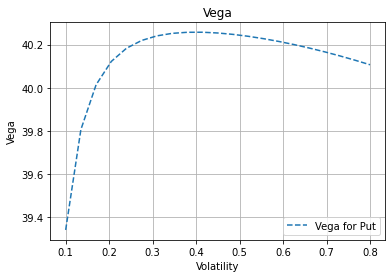

In [85]:
fig = plt.figure()
plt.plot(vol, Vega, '--')
plt.grid()
plt.xlabel('Volatility')
plt.ylabel('Vega')
plt.title('Vega')
plt.legend(['Vega for Put'])

In [86]:
SV = np.linspace(S0-200,S0+300,51)
TV = np.linspace(0.5, 2, 51)
Vega = np.zeros((len(TV),len(SV)))
for j in range(len(SV)):
    for i in range(len(TV)):
        Vega[i,j] = vega(SV[j], K, TV[i], r, q, sigma)

C:\Users\belya\New folder\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


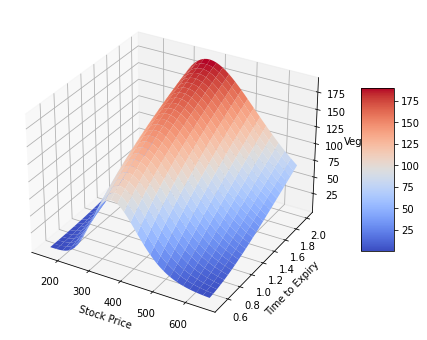

In [87]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d') #3d plot 
SV, TV = np.meshgrid(SV, TV) 
surf = ax.plot_surface(SV, TV, Vega, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Vega')
fig.colorbar(surf, shrink=0.5, aspect=5);

#### Theta

Theta measures the rate of time decay in the value of an option or its premium. Time decay represents the erosion of an option's value or price due to the passage of time. 

In [88]:
def theta(S, K, T, r, q, vol):
    # theata of put option
    #S: stock price
    #K: strike price 
    # r: annual risk free rate
    #q: divident yield
    #vol: annual volatility 
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    
    theta = vol * S * np.exp(-q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [89]:
theta(S0, K, T, r, q, sigma )

71.5935365998674

In [90]:
TH= np.linspace(0.25,3,12)

Theta = np.zeros((len(TH),1))
for i in range(len(TH)):
    Theta[i] = theta(S0, K, TH[i], r, q, sigma)

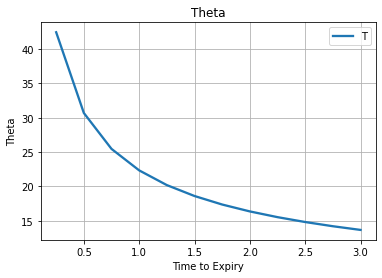

In [91]:
fig = plt.figure()
plt.plot(TH, Theta, '-', lw=2.3)
plt.grid()
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend( 'Theta for Put')

In [92]:
SHX = np.linspace(S0-200,S0+300,51)
THX = np.linspace(0.5, 2, 51)
Theta = np.zeros((len(THX),len(SHX)))
for j in range(len(SHX)):
    for i in range(len(THX)):
        Theta[i,j] = theta(SHX[j], K, THX[i], r, q, sigma)

C:\Users\belya\New folder\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


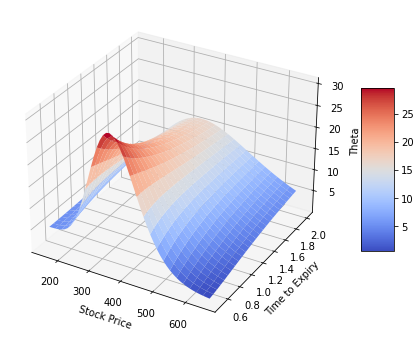

In [93]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
SHX, THX = np.meshgrid(SHX, THX)
surf = ax.plot_surface(SHX, THX, Theta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Theta')
fig.colorbar(surf, shrink=0.5, aspect=5);